## Warning
Not the definitive version

In [2]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

import mpstyle
mpstyle.mpSetParamStyle("code")
matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3

<div class="alert alert-danger">

<b>Ce notebook est à remplir au fur et à mesure du cours et constituera votre rapport sur les trois premières journées de cours. Les questions entourées du symbole $\star$ sont à traiter en dehors du cours.</b></div>

<h1 class="text-center">EISC-211 : Méthodes de Monte-Carlo</h1>

<a id="INTROMARKOV"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">V. Introduction aux chaînes de Markov</h1>

<h2> V.1. Vitesse(s) de convergence(s)</h2>

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.1.</b> La fonction suivante génère une suite $(X_k, k \geq 0)$ : quelles sont les valeurs prises par cette suite ? Expliquez simplement sa dynamique.</p>

In [3]:
def Markov_intro(t_max, p, init):
    X = np.zeros(t_max)
    X[0] = init
    for time in range(1, t_max):
        if (np.random.random() < p):
            X[time] = X[time-1];
        else:
            X[time] = 1 - X[time-1];
    return X

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.1.</b> </div>

Les valeurs prises par la suite sont $X_0$ et $1-  X_0$. Et on a pour $x \in \Omega$ :

$\displaystyle P(X_{k+1} = x) = p \cdot P(X_k = x) + (1-p) \cdot P(X_k = 1-x)$

La suite oscille a priori entre les deux valeurs, et la valeur de $p$ est la probabilité de ne pas changer de valeur $p = P(X_{k+1} = x | X_k = x) $

---

<div class="alert alert-success">

On dit qu'une suite $(Y_n)$ satisfait le <b>théorème ergodique</b> si la suite $(\bar Y_N)$ des moyennes empirique converge presque sûrement vers une constante, <i>i.e.</i> s'il existe une constante $\mu$ telle que $\displaystyle \bar Y_N = \frac{1}{N} \sum_{k=1}^N Y_k \xrightarrow[N \to \infty]{p.s.} \mu. $ </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION V.1.2.</b> Une suite i.i.d. satisfait-elle le théorème ergodique ? Justifiez votre réponse.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.2.</b> </div>

Oui (LGN ?)

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.3.</b> Utilisez le script suivant pour vérifier que $(X_t)$ satisfait le théorème ergodique. Pour quelles valeurs de $p$ la convergence est-elle la plus rapide ? La condition initiale joue-t-elle un rôle ? Expliquez pourquoi.</p>

Text(0, 0.5, 'Moyenne empirique')

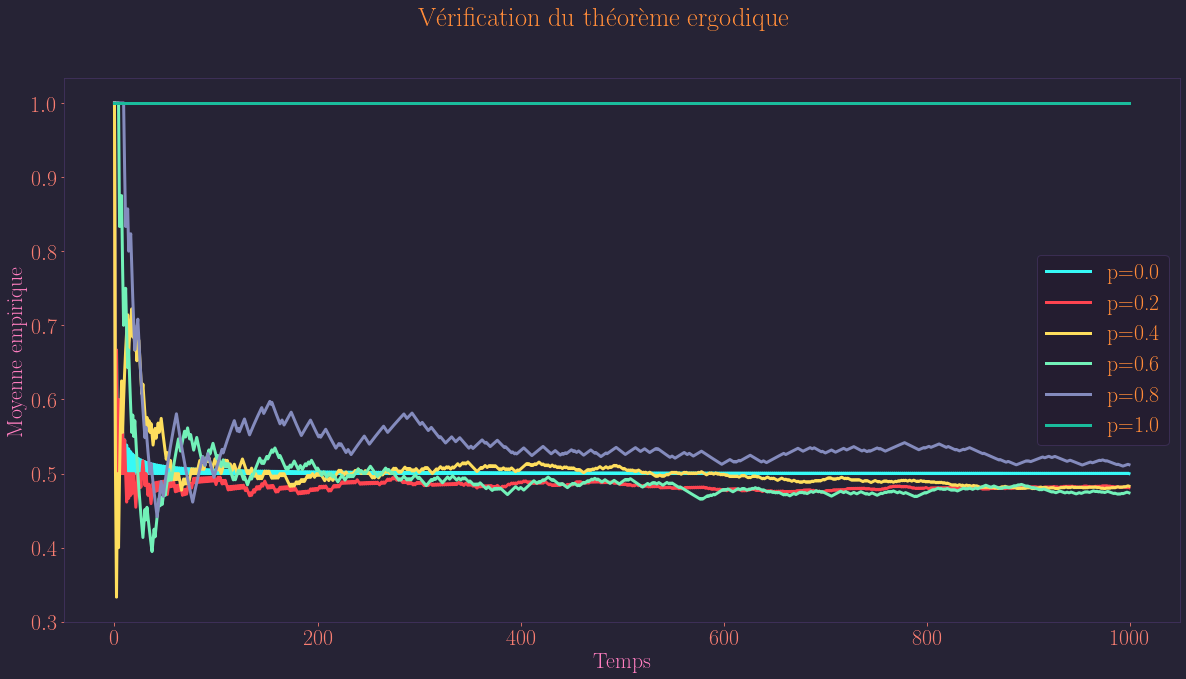

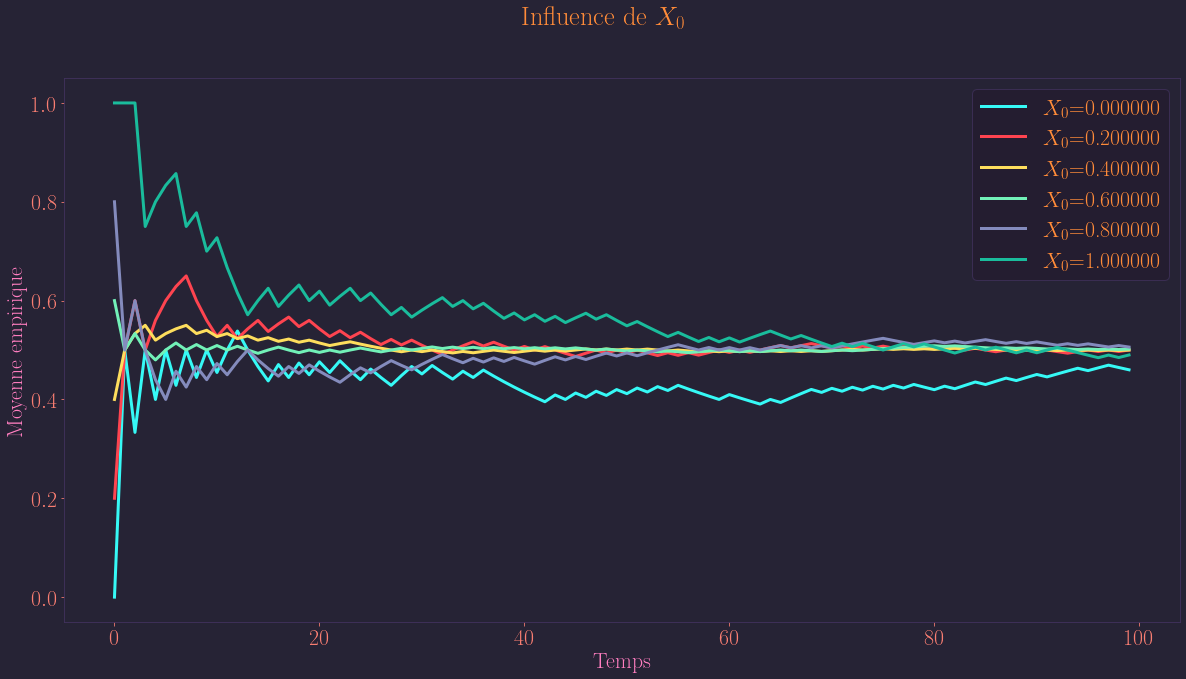

In [4]:
t_max = 10**3
val_p= np.arange(0,1.1,.2)
nb_p = len(val_p)

fig, ax = plt.subplots()
for i in range(nb_p):
    p = val_p[i]
    traj = Markov_intro(t_max, p, 1)
    ax.plot(range(t_max), np.divide(np.cumsum(traj), range(1,1+len(traj))), label=f"p={p:.1f}")
plt.legend()
plt.suptitle("Vérification du théorème ergodique")
plt.xlabel("Temps")
plt.ylabel("Moyenne empirique")

t_max = 10**2
val_x0 = np.arange(0,1.1,.2)

p = 0.3

fig, ax = plt.subplots()
for x in val_x0 :
    traj = Markov_intro(t_max, p, x)
    ax.plot(range(t_max), np.divide(np.cumsum(traj), range(1,1+len(traj))), label=fr"$X_0$={x:1f}")
plt.legend()
plt.suptitle(r"Influence de $X_0$")
plt.xlabel("Temps")
plt.ylabel("Moyenne empirique")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.3.</b> </div>

Plus $p$ est faible plus la suite converge vite, en effet les oscillations sont plus fréquentes. Contrairement à $p$ élevé où il peut il y avoir de longues séries consécutives de la même valeur.

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.4.</b> Pour quelle(s) valeur(s) de $p$ la suite $(X_t)$ est-elle i.i.d.? Concluez.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.4.</b> </div>

Pour les cas triviaux et extrêmes $p= 0$ et $p=1$, pour $p=1$ les variables ne sont pas aléatoires. Et pour $p=0$ les variables oscillent entre 2 valeurs.

---

<div class="alert alert-success">

 On rappelle qu'une suite $(Y_n)$ de variables aléatoires à valeurs entières converge en loi vers une variable aléatoire $Y_\infty$, ce que l'on note $Y_n \stackrel{\text{d}}{\to} Y_\infty$, si $P(Y_n = k) \to P(Y_\infty = k)$ pour tout $k \in \mathbb{N}$. </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.5.</b> Proposez une méthode numérique pour vérifier que $X_n \stackrel{\text{L}}{\to} X_\infty$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.5.</b> </div>

On va simuler $N$ chaines de Markov, et estimer avec une moyenne empirique sur ces échantillon $P(X_k=X_0)$ pour chaque $k$ et montrer que cette probabilité converge vers une valeur $p_\infty$.

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.6.</b> Complétez le script suivant pour vérifier numériquement que $X_n \stackrel{\text{L}}{\to} X_\infty$. Quelle est la limite ? Dépend-elle de $p$? Expliquez comment jouer sur la condition initiale pour que la chaîne de Markov démarre directement à l'équilibre.</p>

Text(0, 0.5, 'Estimation de la loi')

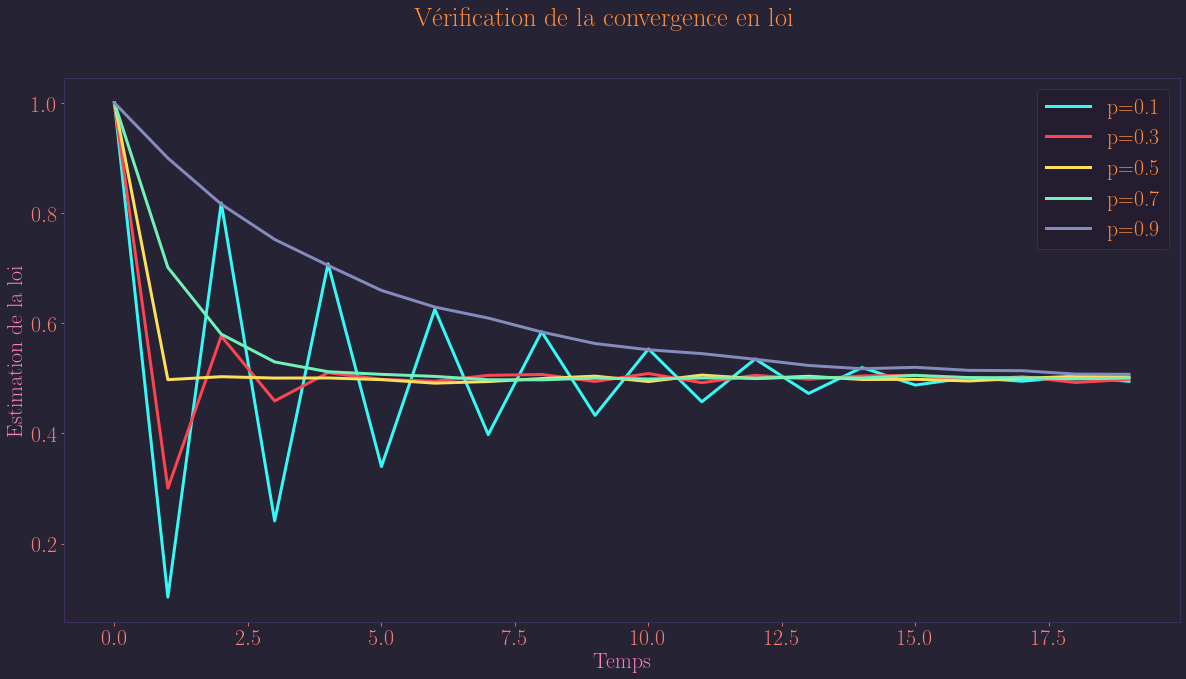

In [5]:
t_max = 2*10**1
N = 10**4

val_p = np.arange(.1,1,.2)

fig, ax = plt.subplots()
for p in val_p :
    ech = np.zeros((N,t_max))
    for i in range(N) :
        ech[i,:] = Markov_intro(t_max, p, 0)
    estimation_loi = np.average( ech == 0, axis=0)
    ax.plot(range(t_max), estimation_loi, label=f"p={p:.1f}")
plt.legend()
plt.suptitle("Vérification de la convergence en loi")
plt.xlabel("Temps")
plt.ylabel("Estimation de la loi")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.6.</b> </div>

La limite est une loi de Bernouilli de paramètre $p_\infty=0.5$, et ce indépendamment de $X_0$, ou de $p$, on peut avoir la convergence directement en prenant $X_0=0.5$, mais ce cas est peu intéressant...

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.7.</b> Pour quelles valeurs de $p$ la convergence est-elle la plus rapide ? Comparez à la réponse de la question V.1.3 et commentez.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.7.</b> </div>

La convergence est plus rapide pour les valeurs de $p$ proche de $0.5$, en opposition à la qestion V.1.3 où on voulait $p$ faible. Mais c'est juste parce que l'on ne mesure pass la même chose. Ici on mesure pour chaque $k$ un "$p$ effectif", et donc plus $p$ est proche de la limite, plus la convergence est rapide. Là où à la question V.1.3 on mesurait la moyenne empirique de la valeur de $X_k$, donc le but était d'avoir beaucoup d'oscillations.

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.1.8.</b> Vérifiez numériquement que $\displaystyle \sqrt N \left( \bar X_N - \frac{1}{2} \right)$ suit approximativement une loi normale pour $N$ grand et faites le lien avec le théorème central limite.</p>

In [6]:
A = np.array([[1,2,3],[4,5,6]])
print(f"Axis 0 : sum = {np.sum(A,axis=0)}\nAxis 1 : sum = {np.sum(A,axis=1)}")

Axis 0 : sum = [5 7 9]
Axis 1 : sum = [ 6 15]


In [7]:
t_max = 10**4
N = 10**4
p = .2
comp = 0
ech = np.zeros((N,t_max))
for i in range(N) :
    ech[i,] = Markov_intro(t_max,p,0)
    comp = int(1000*i/(N-1))/10
    print(f"\r[" + "="*int(comp/4) + " "*int((100-comp)/4) + f"] {comp:.2f}%",end="")
moy  = np.sum(ech, axis=1)/t_max

est = np.sqrt(t_max)*(moy - 0.5)

[=========================] 100.00%

Text(0.5, 0.98, 'Vérification du théorème central limite')

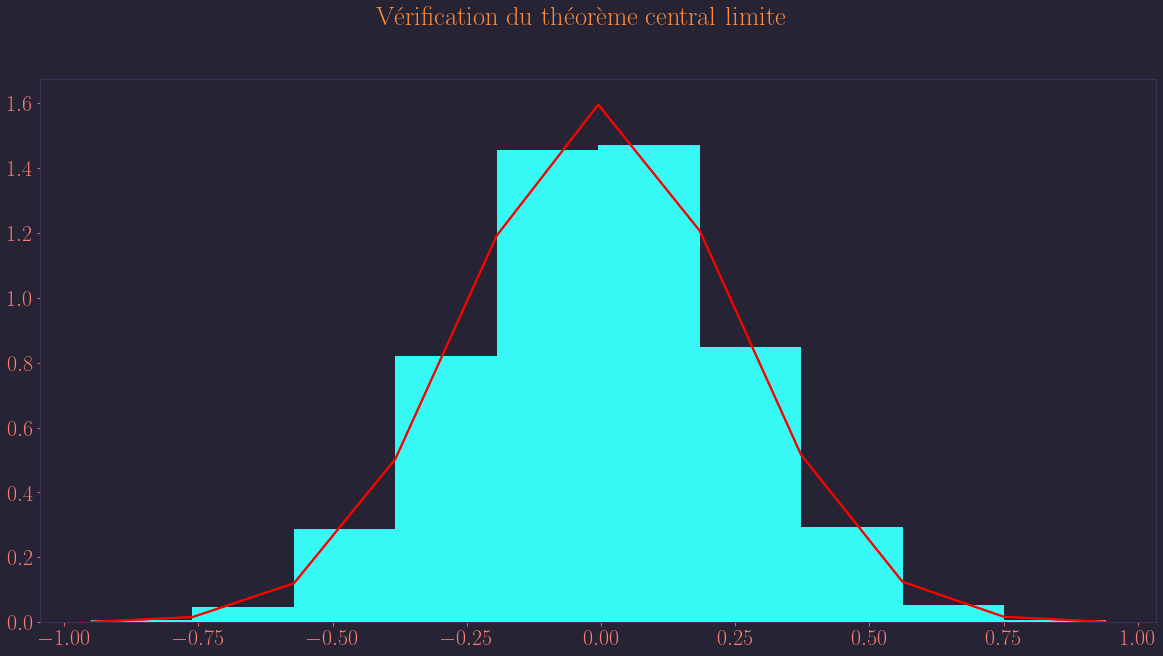

In [8]:
binwidth = 120/N

fig, ax = plt.subplots()
# count, bins, ignored = plt.hist(ech, normed=True)
count, bins, ignored = plt.hist(est, density=True) #, bins=np.arange(min(est), max(est) + binwidth, binwidth))
sigma = np.std(est)
mu = np.mean(est)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
ax.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma), linewidth=2, color='r')
plt.suptitle("Vérification du théorème central limite")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.1.8.</b> </div>

<h2> V.2. File d'attente</h2>

On considère la chaîne de Markov sur $\mathbb{N}$ définie de la manière suivante : $X_{t+1} = F(X_t, U_t)$ avec
$$ F(x, u) = \begin{cases}
	x + (-1)^{{\bf 1}(u > p)} & \text{ si } x > 0,\\
	{\bf 1}(u \leq p) & \text{ si } x = 0.
\end{cases} $$

<p class="bg-primary" style="padding:1em"><b>QUESTION V.2.1.</b> Donnez la matrice de transition de cette chaîne de Markov.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.2.1.</b> </div>

$X_{k+1} = A X_k$, où on a :
$$A = \begin{pmatrix}
1-p    & 1-p    & 0      & \cdots & \\
p      & 0      &  1-p   &  0     & \cdots\\
0      & p      & \ddots & \ddots & \ddots\\
\vdots & 0      & \ddots & \ddots & \ddots\\
 & \vdots & \ddots & \ddots & \ddots\\
\end{pmatrix}$$
$a_{11} = 1 - p, \;a_{i,i+1} = 1-p, \; a_{i+1,i} = p$

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.2.2.</b> Complétez la fonction <code>file_attente</code> puis utilisez le script suivant pour tracer plusieurs trajectoires en fonction de $p$. Quel comportement observez-vous pour $p > 1/2$? Y a-t-il convergence ? Expliquez intuitivement pourquoi.</p>

In [9]:
def file_attente(t_max, p, init):
    X = np.zeros(t_max)
    X[0] = init
    for i in range(1,t_max) :
        x = X[i-1]
        yes = np.random.random() < p
        if x == 0 :
            X[i] = int(yes)
        else :
            X[i] = x + 1 if yes else x - 1
    return X

Text(0, 0.5, 'X')

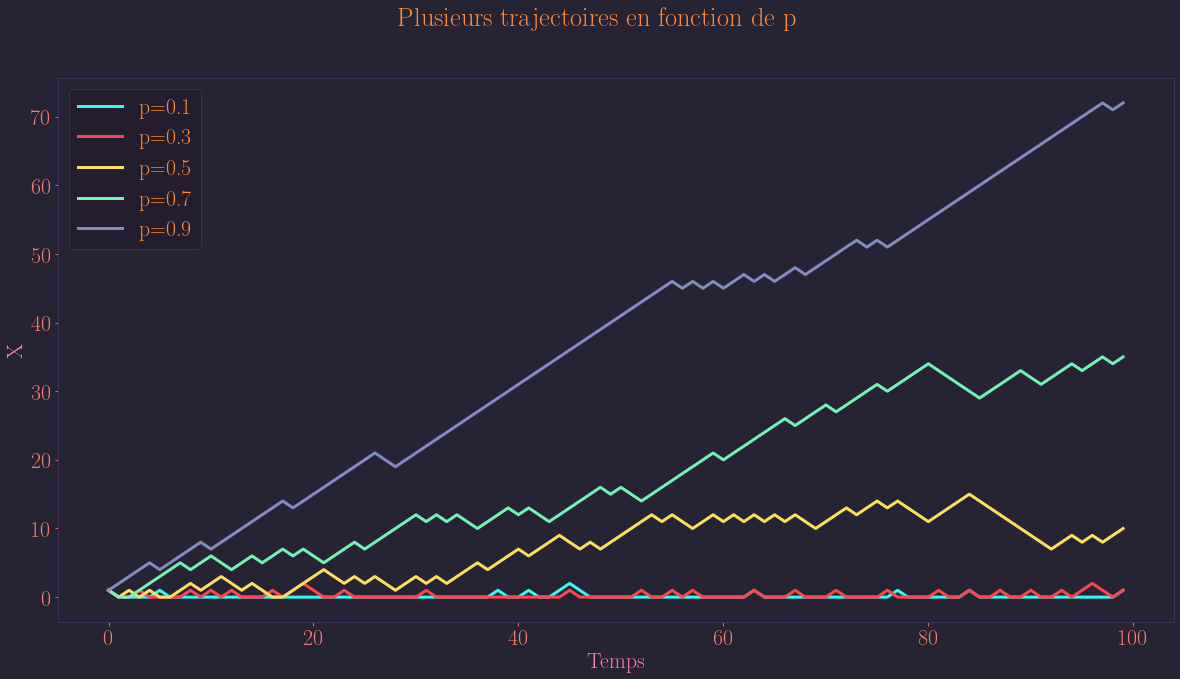

In [10]:
t_max = 10**2
val_p = np.arange(.1,1,.2)
nb_p = len(val_p)

fig, ax = plt.subplots()
for i in range(nb_p):
    p = val_p[i]
    traj = file_attente(t_max, p, 1)
    ax.plot(range(t_max), traj, label=f"p={p:.1f}")
plt.legend()
plt.suptitle("Plusieurs trajectoires en fonction de p")
plt.xlabel("Temps")
plt.ylabel("X")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.2.2.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.2.3.</b> Complétez le script suivant pour montrer que pour $p < 1/2$, le théorème ergodique est satisfait. Vous pouvez utiliser la fonction <code>np.cumsum</code>.</p>

Text(0, 0.5, 'Moyenne empirique')

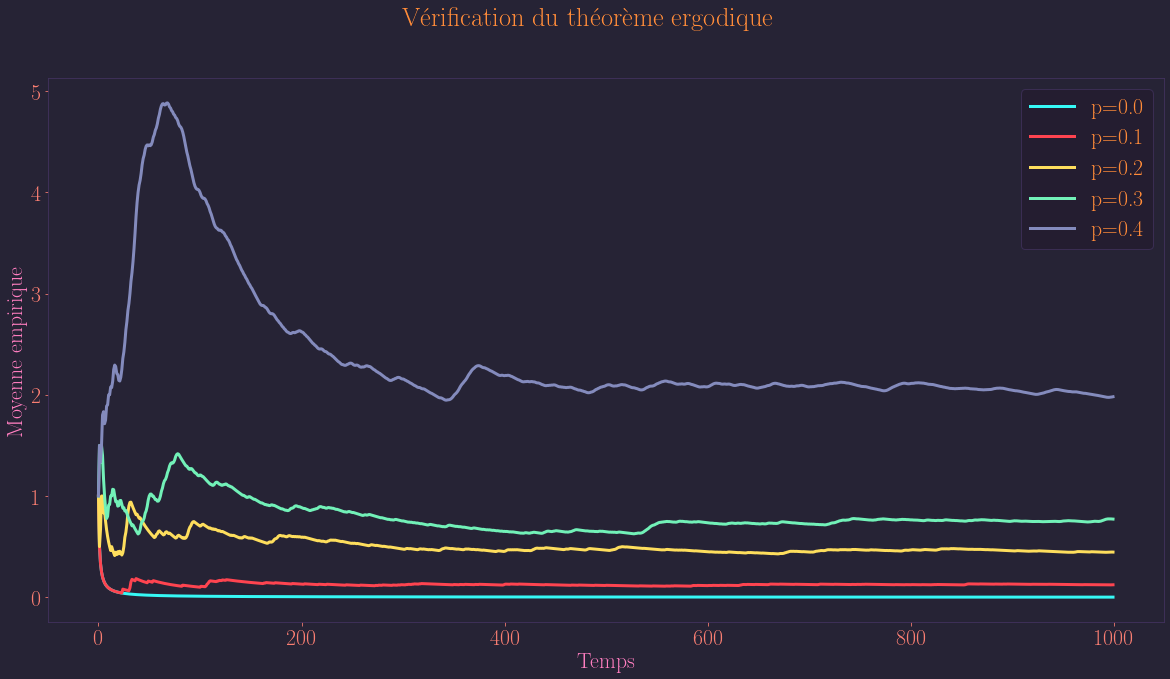

In [11]:
t_max = 10**3
val_p = np.arange(.0,.5,.1)
nb_p = len(val_p)

fig, ax = plt.subplots()
for i in range(nb_p):
    p = val_p[i]
    traj = file_attente(t_max, p, 1)
    ax.plot(range(t_max), np.divide(np.cumsum(traj), range(1,1+len(traj))), label=f"p={p:.1f}")
plt.legend()
plt.suptitle("Vérification du théorème ergodique")
plt.xlabel("Temps")
plt.ylabel("Moyenne empirique")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.2.3.</b> </div>

Oui

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION V.2.4.</b> Complétez le script suivant pour montrer que pour $p < 1/2$, $X_n$ converge en loi. Parmi la loi de Poisson et la loi géométrique, laquelle choisiriez-vous ?<br>
<b>Indication</b> Comment choisir le paramètre des lois que vous testez ?</p>

In [12]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

In [13]:
t_max = 10**3
N = 10**4

p = .47
ech = np.zeros((N))
for i in range(N):
    ech[i] = file_attente(t_max, p, 0)[-1]
    comp = 100*i/(N-1)
    print(f"\r[" + "="*int(comp/4) + " "*int((100-comp)/4) + f"] {comp:.2f}%",end="")


[=========================] 100.00%

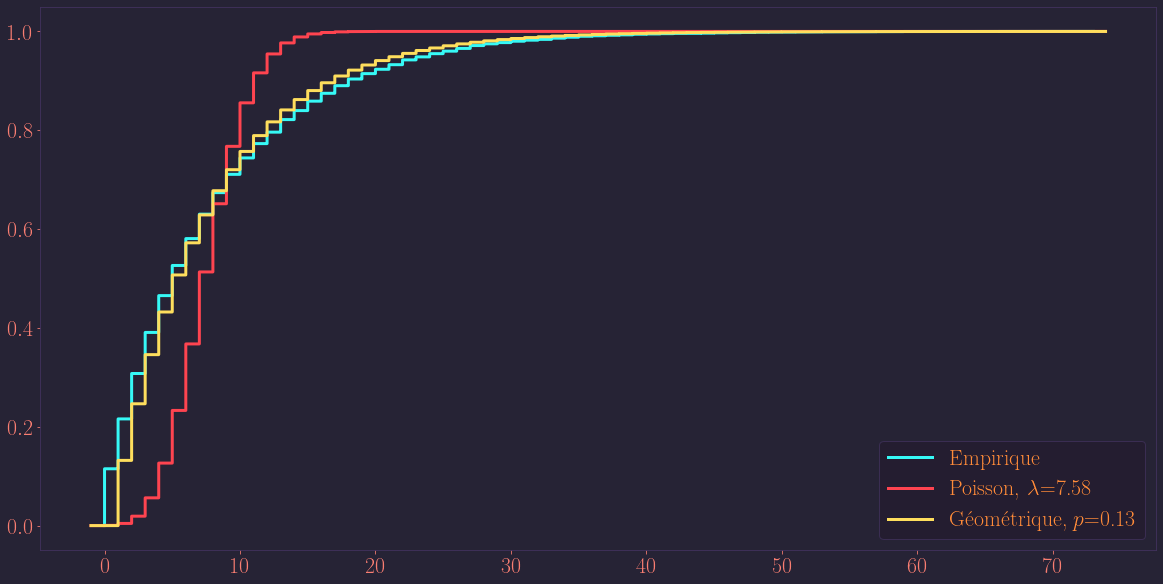

In [14]:
fig, ax = plt.subplots()

moy = np.average(ech)

x = np.arange(np.min(ech)-1, np.max(ech)+1, .1)
s, y = ecdf(ech)
ax.step(s, y, label="Empirique")

par_poisson = moy
par_geometrique = 1/moy
ax.step(x, stats.poisson.cdf(x, par_poisson), label=fr"Poisson, $\lambda$={par_poisson:.2f}")
ax.step(x, stats.geom.cdf(x, par_geometrique), label=fr"Géométrique, $p$={par_geometrique:.2f}")
plt.legend()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION V.2.3.</b> </div>

<a id="MCMC"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">VI. Méthodes de Monte-Carlo à base de chaînes de Markov</h1>

<div class="alert alert-success">

Si $(X_n)$ est une chaîne de Markov de mesure stationnaire $f$, alors le théorème ergodique pour les chaînes de Markov garantit que
$$ \displaystyle \widehat I^{\text{MCMC}} = \frac{1}{N} \sum_{k=1}^N \phi(X_k) $$
est un estimateur convergent de $\int \phi f$: on a remplacé un échantillon i.i.d. par la trajectoire d'un processus de Markov, on parle alors de méthode <b>MCMC</b> (par opposition à IIDMC). Cette méthode n'a d'intérêt que si l'on sait générer une chaîne de Markov avec une probabilité stationnaire donnée : l'<b>algorithme de Metropolis-Hastings</b> fait précisément cela, il s'agit de la pierre angulaire des méthodes MCMC.</div>

<h2> VI.1. Algorithme de Metropolis–Hastings</h2>

L'algorithme de Metropolis-Hastings est un algorithme général qui permet de générer une chaîne de Markov avec une distribution invariante donnée. Soit $\pi$ une mesure de probabilité sur un ensemble dénombrable $\mathfrak{X}$ et $K: \mathfrak{X} \times \mathfrak{X} \to [0,1]$ un noyau de transition, *i.e.* pour tout $x \in \mathfrak{X}$ la famille $K(x, \cdot) = (K(x,y), y \in \mathfrak{X})$ définit une mesure de probabilité sur $\mathfrak{X}$. L'algorithme de Metropolis-Hastings construit la chaîne de Markov suivante :
1. Tirer $Y_k$ selon la loi $K(X_k, \, \cdot)$;
2. Calculer
$$ \displaystyle \varrho(X_k, Y_k) = \min \left( 1, \frac{\pi(Y_k)}{\pi(X_k)} \frac{K(Y_k, X_k)}{K(X_k, Y_k)} \right); $$
3. Choisir $\displaystyle X_{k+1} = \begin{cases}
    Y_k & \text{ avec probabilité } \varrho(X_k, Y_k),\\
    X_k & \text{ avec probabilité } 1 - \varrho(X_k, Y_k).
\end{cases} $

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.1.1.</b> Calculez $p_{xy} = P(X_2 = y \mid X_1 = x)$ puis montrez que $\pi_x p_{xy} = \pi_y p_{yx}$. Déduisez-en que $X$ admet $\pi$ comme probabilité stationnaire.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.1.1.</b> </div>


---

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.1.2.</b> Décrivez simplement cet algorithme lorsque le noyau de transition ne dépend pas de l'état de départ, <i>i.e.</i> $K(x, \cdot \,) = \mu(\cdot)$ pour une certaine mesure de probabilité $\mu$ et tout $x \in \mathfrak{X}$. Faites le lien avec la méthode du rejet.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.1.2.</b> </div>

Rep

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.1.3.</b> Décrivez simplement $Y_t$ lorsque le noyau de transition est symétrique, <i>i.e.</i> tel que $K(x, y) = K(y, x)$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.1.3.</b> </div>

Rep

---

<p class="bg-primary" style="padding:1em"><b>QUESTION VI.1.4.</b> Discutez des utilisations et avantages potentiels de l'algorithme de Metropolis-Hastings.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.1.4.</b> </div>

Rep

---

<div class="alert alert-success"> 

Dans le cas à densité, l'algorithme de Metropolis--Hastings est le même : un noyau de transition est une application $K: \mathbb{R}^d \times \mathbb{R}^d \to [0,1]$ telle que $K(x, \cdot \,)$ est une densité sur $\mathbb{R}^d$ pour chaque $x \in \mathbb{R}^d$, et $\pi$ est remplacée par une densité $f$ sur $\mathbb{R}^d$. </div>

<h2> VI.2. Vitesse de convergence de la méthode MCMC</h2>

La méthode MCMC consiste donc à générer à l'aide de l'algorithme de Metropolis-Hastings une chaîne de Markov ayant une densité cible $f$ comme distribution stationnaire, puis de considérer l'estimateur
$$ \widehat I^{\text{MCMC}} = \frac{1}{N} \sum_{k=1}^N \phi(X_k) $$
qui est convergent par le théorème ergodique pour les chaînes de Markov.

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.2.1.</b> A-t-on comme dans le cas IIDMC $\displaystyle \text{Var}(\widehat I^{\text{MCMC}}) = \frac{\text{Var}(\phi(X_1))}{N}$? Pourquoi?</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.2.1.</b> </div>

Non car les variables $X_k$ ne sont pas i.i.d

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.2.2.</b> Proposez une méthode numérique pour estimer $\text{Var}(\widehat I^{\text{MCMC}})$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.2.2.</b> </div>

Rep

---

<h2> VI.3. Méthode MCMC pour l’estimation d'une intégrale sur la sphère</h2>

On revient à l'exemple de la sphère. On propose quatre noyaux de transition pour simuler une chaîne de Markov qui admette la distribution uniforme dans la sphère comme probabilité stationnaire :
* **Noyau uniforme - indépendant:** $K(x, \cdot \,)$ est la mesure uniforme sur $[-1,1]^d$;
* **Noyau uniforme - marche aléatoire:** $K(x, y) \propto {\bf 1}(\lVert y - x \rVert \leq \delta)$;
* **Noyau beta - indépendant:** $K(x, \cdot \,) = g_\theta$ avec $g_\theta$ introduit dans le BE sur l'échantillonnage préférentiel;
* **Noyau gaussien - marche aléatoire:** $K(x, y) \propto \exp \left( -\lVert y - x \rVert^2 / (2 \sigma^2) \right)$.

<p class="bg-primary" style="padding:1em"><b>QUESTION VI.3.1.</b> Décrivez par écrit l'algorithme de Metropolis-Hastings  dans chacun des ces cas.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.3.1.</b> </div>

Rep

---

L'objectif de cette section est d'utiliser la chaîne de Markov produite par l'algorithme de Metropolis-Hastings et le théorème ergodique pour estimer la valeur d'une intégrale sur la sphère,
$$ J = \int \phi(x) f_{\mathbb{S}}(x) dx $$
où $f_{\mathbb{S}}$ est la densité de la loi uniforme sur la sphère de rayon $1$ et $\phi(x) = \Vert x \Vert$ est la fonction à intégrer.

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.3.2.</b> Complétez les fonctions <code>estimation_MCMC_XXX</code> qui implantent ces algorithmes de Metropolis-Hastings. Pour vérifier votre code, vous vérifierez numériquement et en petite dimension que ces quatre chaînes de Markov ont bien comme distribution stationnaire la mesure uniforme sur la sphère. Que vaut $J$? Comparez vos résultats avec la valeur attendue.</p>

In [67]:
def g(x:np.array, theta:float) -> np.array :
    '''
    x est une matrice avec N lignes et d colonnes
    d est la dimension de l'espace
    N est la taille de l'echantillon
    La fonction renvoie un vecteur de longueur N où la k-ème entrée correspond à la fonction g
    appliquée à la k-ème ligne.
    '''
    dimension = x.shape[1]
    #taille_echantillon = x.shape[0]
    c =(2 * special.gamma(2*theta) )/ (4**np.float64(theta) * special.gamma(theta)**2)
    return c**dimension * np.power(np.prod(1 - np.power(np.float64(x), 2), 1), (np.float64(theta) - 1))

In [81]:
def progress(comp) :
    print(f"\r[" + "="*int(comp/2) + " "*int((100-comp)/2) + f"] {comp:.2f} %",end="")

V = lambda d : np.pi**(d/2)/(special.gamma(d/2 + 1))

# pi indicatrice sphère non normée (pas besoin)
def pi(x: np.array(float)) -> np.array(float) :
    return np.linalg.norm(x) <= 1 


def estimation_MCMC_unif_ind():
    x = x0
    # Pas besoin de normer K car apparaît seulement comme quotient
    # Sinon K = K/2**d
    K = lambda x,y : np.prod(np.abs(y) <= 1) 
    for _ in range(N_step) :
        y = 2 * np.random.random(dim) - 1
        rho = min(1, pi(y) * K(y,x)/(pi(x) * K(x,y)))
        if np.random.random() < rho :
            x = y # else x = x
    return x

def estimation_MCMC_unif_MA(delta: float):
    x = x0
    K = lambda x,y : np.prod(np.abs(y-x) <= delta) / (delta**dim)
    for _ in range(N_step) :
        y = x + (2*np.random.random(dim)-1)*delta
        rho = min(1, pi(y) * K(y,x)/(pi(x) * K(x,y)))
        if np.random.random() < rho :
            x = y # else x = x
    return x

#TODO optimize, no need for y and K eval to be in loop
#En faible dimension prendre theta proche de 1
# En dimension plus élevée prendre theta plus élevé
def estimation_MCMC_beta(theta: float):
    x = x0
    K = lambda x,y : g(np.array([y]), theta)
    for _ in range(N_step) :
        y = np.random.beta(theta,theta,dim)
        rho = min(1, pi(y) * K(y,x)/(pi(x) * K(x,y)))
        if np.random.random() < rho :
            x = y # else x = x
    return x

def estimation_MCMC_gaussien(sigma: float):
    x = x0
    K = lambda x,y : np.exp(- np.linalg.norm(y-x)**2 / (2*sigma**2))
    for _ in range(N_step) :
        y = np.random.normal(x,sigma,size = [dim])
        rho = min(1, pi(y) * K(y,x)/(pi(x) * K(x,y)))
        if np.random.random() < rho :
            x = y # else x = x
    return x


def estim_J(N_ech: int) -> np.array(float) :
    #Sampling
    ech = np.zeros((4,N_ech,dim))
    for i in range(N_ech) :
        ech[0,i] = estimation_MCMC_unif_ind()
        ech[1,i] = estimation_MCMC_unif_MA(0.1)
        ech[2,i] = estimation_MCMC_beta(0.7)
        ech[3,i] = estimation_MCMC_gaussien(0.5)
        #progress display
        progress(100 * i/(N_ech-1))
    #Estimation
    est = np.zeros(4)
    for i in range(4) :
        est[i] = np.average(np.linalg.norm(ech[i],axis = 1))
    return est


In [86]:
dim = 5
N_step = 10**2
N = 10**3
x0 = np.zeros((dim))
J = estim_J(N)

print(f"\nEstimations en dimension d = {dim} :")
print(f"Noyau uniforme indépendant : {J[0]:.3f}")
print(f"Noyau uniforme MA :          {J[1]:.3f}")
print(f"Noyau beta indépendant :     {J[2]:.3f}")
print(f"Noyau gaussien MA :          {J[3]:.3f}")
print(f"\nValeur attendue : J = {J_exact(dim):.3f}")

[==================================================] 100.00 %
Estimations en dimension d = 5 :
Noyau uniforme indépendant : 0.830
Noyau uniforme MA :          0.832
Noyau beta indépendant :     0.782
Noyau gaussien MA :          0.830

Valeur attendue : J = 0.833


<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.3.2.</b> </div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION VI.3.3.</b> Analysez la performance de ces quatre méthodes d'estimation de l'intégrale : pour chaque algorithme, vous devrez notamment :
<br>
1. tracer l'évolution de l'écart relatif en fonction de la dimension, pour un budget de simulation et des valeurs de paramètres que vous aurez choisis;
<br>
2. discuter l'influence des paramètres (si le noyau en a);
<br>
3. discuter l'influence de la condition initiale $X_0$.
</p>

In [84]:
def J_exact(d:int) -> float :
    return d/(d+1) 

<div class="alert alert-warning"><b>REPONSE A LA QUESTION VI.3.3.</b> </div>